In [9]:
%run 'pymol_and_pdb_functions.py'
start_pymol()

In [1]:
%run 'ks01_Functions_only.ipynb'
%run 'pymol_and_pdb_functions.py'

notebook_prefix = 'ks16'
image_counter = Counter()

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Relative >>> absolute position

In [2]:
position_translation = pd.read_table(files_dump_folder + 'position_translation.csv')
position_translation.set_index('relative_position', inplace=True)

def get_absolute_position(segment_number, relative_position):
    return int(position_translation.iloc[relative_position]['S'+str(segment_number)])

### Reading data on sign epistasis from Lucas

In [3]:
lucas_sign_epistasis = pd.read_csv(files_dump_folder + 'sign_epistasis/' + 'lucas_sign_epistasis.csv')
lucas_reciprocal_sign_epistasis = pd.read_csv(files_dump_folder + 'sign_epistasis/' + 'lucas_reciprocal_sign_epistasis.csv')

p_value_threshold = 0.01
filtered = lucas_sign_epistasis[lucas_sign_epistasis['pBon'] < p_value_threshold]
sign_epistasis_positions = set.union(set(filtered['VarPos_absolute'].values), 
                                                set(filtered['SubPos_absolute'].values))
sign_epistasis_positions = sorted([int(s) for s in sign_epistasis_positions])
print len(sign_epistasis_positions), 'positions under sign epistasis'

reciprocal_sign_epistasis_positions = set.union(set(lucas_reciprocal_sign_epistasis['position1'].values), 
                                                set(lucas_reciprocal_sign_epistasis['position1'].values))
reciprocal_sign_epistasis_positions = sorted([int(s) for s in reciprocal_sign_epistasis_positions])
print len(reciprocal_sign_epistasis_positions), 'positions under reciprocal sign epistasis'

94 positions under sign epistasis
59 positions under reciprocal sign epistasis


### Reading 24-mer structure

In [4]:
his3_aligned_to_4lom_assembly_file = os.path.join(structure_predictions_folder, 'his3_24mer_assembly', 
                                                  'his3_swiss_aligned_to_4lom_assembly.pdb')
structure = Bio.PDB.PDBParser().get_structure('his3_swiss_assembly', his3_aligned_to_4lom_assembly_file)
model = structure[0]

/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain A is discontinuous at line 37657.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain B is discontinuous at line 37675.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain C is discontinuous at line 37693.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain D is discontinuous at line 37711.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructionWarning: WARNING: Chain E is discontinuous at line 37729.
  PDBConstructionWarning)
/Users/karen/anaconda/lib/python2.7/site-packages/Bio/PDB/StructureBuilder.py:85: PDBConstructi

In [5]:
substrates = [r for chain in model.get_chains() for r in chain if r.get_resname() == 'IYP']
mn = [r for chain in model.get_chains() for r in chain if r.get_resname() == ' MN']

### Calculating distances

In [110]:
distance_dict = OrderedDict()
prefix = 'res_'

constant_chain = model['A']
positions_in_crystal = [r.id[1] for r in constant_chain.get_residues() if r.get_resname() in aa3]

for residue in constant_chain.get_residues():
    if residue.get_resname() in aa3:
        distance_dict[prefix + '%s' %residue.id[1]] = OrderedDict()

        # distances to other residues
        for position in positions_in_crystal:
            distances = []
            for other_chain in model.get_chains():
                distances.append(get_distance_between_residues(residue, other_chain[position]))
            distance_dict[prefix + '%s' %residue.id[1]][prefix + '%s' %position] = min(distances)

        # distances to Mn ions
        for position in [302, 303, 304]:
            distances = []
            for other_chain in model.get_chains():
                other_residue = [r for r in other_chain if position == r.id[1]][0]
                distances.append(get_distance_between_residues(residue, other_residue))
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '%s' %position] = min(distances)
        distance_dict[prefix + '%s' %residue.id[1]]['Mn_substrate_bound'] = min(
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '302'],
            distance_dict[prefix + '%s' %residue.id[1]]['Mn_' + '303'])
            
        # distances to substrate
        for position in [301]:
            distances = []
            for other_chain in model.get_chains():
                other_residue = [r for r in other_chain if position == r.id[1]][0]
                distances.append(get_distance_between_residues(residue, other_residue))
            distance_dict[prefix + '%s' %residue.id[1]]['substrate'] = min(distances)
            
structural_data = pd.DataFrame.from_dict(distance_dict, orient='index')
new_index = sorted(structural_data.index.values, key=lambda s: int(s[4:]))
structural_data = structural_data.reindex(new_index)

# structural_data.to_hdf(files_dump_folder + 'distances_within_24mer.hdf', 'data')
# structural_data.to_csv(files_dump_folder + 'distances_within_24mer.csv')

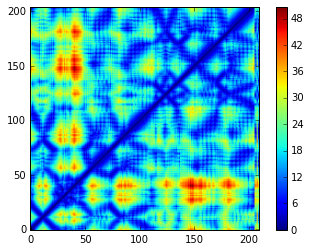

In [121]:
plt.imshow(np.array(structural_data), origin='lower')
plt.colorbar()

### Interface residues

In [123]:
pymol.pymol_argv = ['pymol', '-qc'] # quiet / no GUI
stdout = sys.stdout
stderr = sys.stderr
pymol.finish_launching(['pymol', '-xiq'])
sys.stdout = stdout
sys.stderr = stderr

In [ ]:
import itertools

cmd.reinitialize()
cmd.load(temp_file, 'swiss_assembly')

interfaces = {}
f = FloatProgress(min=0, max=len(list(itertools.combinations(range(24), 2))))
display(f)
for chain_index1, chain_index2 in (itertools.combinations(range(24), 2)):
    chain1, chain2 = ascii_letters_upper[chain_index1], ascii_letters_upper[chain_index2]
    returned = interfaceResidues('swiss_assembly', cA = 'c. %s' %chain1, cB = 'c. %s' %chain2)
    interfaces[chain1, chain2] = returned
    f.value += 1